## Evaluation of accuracy with EfficientNet-B0 without classifier (7 emotions - 36.59% / 5 emotions - 49.12%)

In [51]:
import torch
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from PIL import Image
import numpy as np

In [52]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces\Val_AFEW'
IMG_SIZE = 224

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [53]:
class_to_idx = {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
idx_to_class = {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8'
device = 'cuda:0'
model = torch.load(PATH)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [54]:
def softmax(input):
    modified_input = np.subtract(input, input.max(axis=0, keepdims=True))

    # Get unnormalized probabilities
    exp_values = np.exp(modified_input - np.max(modified_input, axis=0, keepdims=True))
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)

    return probabilities

In [55]:
y_val,y_scores_val=[],[]

for class_name in os.listdir(DATA_DIR):
    if class_name in class_to_idx:
        class_dir=os.path.join(DATA_DIR,class_name)
        y=class_to_idx[class_name]
        for video_name in tqdm(os.listdir(class_dir)):
            video_dir = os.path.join(class_dir,video_name)
            for img_name in os.listdir(video_dir):
                if 'noface' not in img_name:
                    filepath=os.path.join(video_dir,img_name)
                    img = Image.open(filepath)
                    img_tensor = test_transforms(img)
                    img_tensor.unsqueeze_(0)
                    scores = model(img_tensor.to(device))
                    scores=scores[0].data.cpu().numpy()
                    #print(scores.shape)
                    y_scores_val.append(softmax(scores))
                    y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(19962, 8) (19962,)


In [56]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(y_val)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_pred[y_val==i]==i).sum(),(y_val==i).sum(),100*_val_acc))

35.22192165113716
Angry 1220/3297 acc: 37.003336
Contempt 0/0 acc: nan
Disgust 372/2485 acc: 14.969819
Fear 671/1703 acc: 39.401057
Happy 1577/3320 acc: 47.500000
Neutral 798/3693 acc: 21.608448
Sad 1910/3356 acc: 56.912992
Surprise 483/2108 acc: 22.912713


D:\Users\amira\AppData\Local\Temp\ipykernel_1104\1864895788.py:8: RuntimeWarning: invalid value encountered in long_scalars
  _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()


In [57]:
# Model was trained on 8 emotions on AffectNet so we have to delete 1 emotion that is not on AFEW
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(19962, 7)
36.59452960625188


5 emotions that [model](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/emotions-recognition-retail-0003) from OpenVino's OMZ can classify

In [59]:
irrelevant_idxs = [class_to_idx['Contempt'], class_to_idx['Disgust'], class_to_idx['Fear']]

y_scores_val_filtered=y_scores_val[:, [i not in irrelevant_idxs for i in idx_to_class]]
print(y_scores_val_filtered.shape)

y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=[i not in irrelevant_idxs for i in y_val]
y_val_new=np.array([y if y<class_to_idx['Contempt'] else y-3 for y in y_val if y not in irrelevant_idxs])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(19962, 5)
49.125142639786986


## Evaluation of accuracy with EfficientNet-B0 with classifier - 59%

In [3]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [2]:
PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [4]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}
device = 'cuda:0'

In [4]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

Path to directory is organised like DATA_DIR/Val_AFEW/emotion_name/video_name/[images from MTCNN]

In [ ]:
def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            frames_dir=os.path.join(class_dir,video_name)
            X_global_features,X_isface=[],[]
            imgs=[]
            for img_name in os.listdir(frames_dir):
                img = Image.open(os.path.join(frames_dir,img_name))
                img_tensor = test_transforms(img)
                X_isface.append('noface' not in img_name)
                    
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs)>=16:        
                        #global_features,feats,scores=feature_extractor_model.predict(inp)
                        scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)
                
                        #print(global_features.shape,feats.shape,scores.shape)
                        if len(X_global_features)==0:
                            X_global_features=scores
                        else:
                            X_global_features=np.concatenate((X_global_features,scores),axis=0)
                        
                        imgs=[]

            if len(imgs)>0:   
                scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                scores=scores.data.cpu().numpy()
                #print(scores.shape)

                #print(global_features.shape,feats.shape,scores.shape)
                if len(X_global_features)==0:
                    X_global_features=scores
                else:
                    X_global_features=np.concatenate((X_global_features,scores),axis=0)

            X_isface=np.array(X_isface)
            #print(X_global_features.shape,X_feats.shape,X_scores.shape)
            filename2features[video_name]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

Sav and load extracted features

In [5]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_torch.pickle' 

print(MODEL2EMOTIW_FEATURES)

enet_b0_8_afew_torch.pickle


In [9]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [7]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [8]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [68]:
svc_clf = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = svc_clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5963060686015831
Complete accuracy: 0.5900783289817232


In [13]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion = pd.crosstab(y_test, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = classes
confusion.index = classes


<AxesSubplot:title={'center':'Confusion matrix'}>

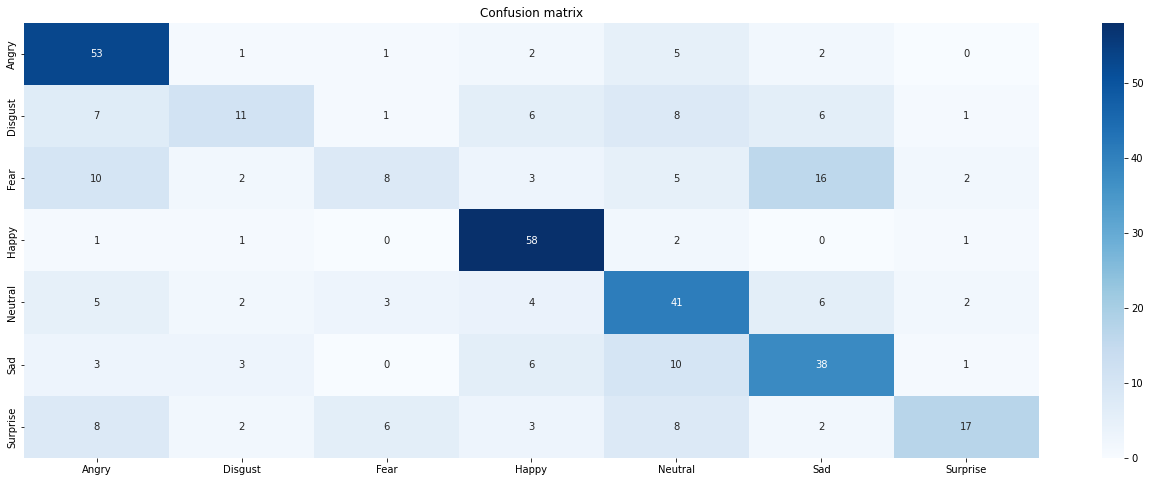

In [19]:
fig = plt.figure(figsize=(50,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

## OpenFace features + classifiers

In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [6]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_torch.pickle' 

print(MODEL2EMOTIW_FEATURES)


enet_b0_8_afew_torch.pickle


In [2]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [2]:
DATA_DIR = r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\openface'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}
device = 'cuda:0'

In [3]:
def create_openface_dataset(data_dir):
    x = []
    y = []
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names without extension
            if 'of_details' not in fn:
                openface_df = pd.read_csv(os.path.join(data_dir,class_name,filename))
                # fill zeroes with mean values where openface failed to detect faces 
                openface_df.loc[openface_df[' success'] == 0] = openface_df.loc[openface_df[' success'] == 0].replace(0, openface_df.loc[openface_df[' success'] == 1].mean())
                # remove some irrelevant columns
                openface_df = openface_df.loc[:, ~openface_df.columns.isin(['frame', ' face_id', ' timestamp', ' confidence', ' success'])]

                total_features=None
                mean_features = (np.mean(openface_df, axis=0))
                std_features = (np.std(openface_df, axis=0))
                max_features = (np.max(openface_df, axis=0))
                min_features = (np.min(openface_df, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
                
                if total_features is not None:
                    x.append(total_features)
                    y.append(emotion_to_index[class_name])

    x=np.array(x)
    y=np.array(y)
    
    print(x.shape,y.shape)
    return x,y

x_train, y_train = create_openface_dataset(os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test = create_openface_dataset(os.path.join(DATA_DIR, 'Val_AFEW'))


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

(773, 1316) (773,)


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

(383, 1316) (383,)


There are 24 videos from Train and 11 videos from Test where OpenFace completely failed to detect faces

In [4]:
bool_x_train = np.isnan(x_train)
openface_has_faces_train = []

for i in range(len(bool_x_train)):
    openface_has_faces_train.append((len(np.where(bool_x_train[i]==1)[0]) == 0))


bool_x_test = np.isnan(x_test)
openface_has_faces_test = []

for i in range(len(bool_x_test)):
    openface_has_faces_test.append((len(np.where(bool_x_test[i]==1)[0]) == 0))

In [64]:
from sklearn import svm,metrics,preprocessing

x_train_norm_of=preprocessing.normalize(x_train[openface_has_faces_train],norm='l2')
x_test_norm_of=preprocessing.normalize(x_test[openface_has_faces_test],norm='l2')


In [69]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=700,use_label_encoder=False)

if True:    
    xgb_clf.fit(x_train, y_train)
    y_pred = xgb_clf.predict(x_test)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Complete accuracy: 0.34986945169712796


Accuracy is higher when passing all data and the same with and without normalization

## Enet + OpenFace Features

In [7]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_torch.pickle' 

print(MODEL2EMOTIW_FEATURES)


enet_b0_8_afew_torch.pickle


In [8]:

with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [9]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_frames, y_train_frames, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_frames, y_test_frames, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

(383, 5120) (383,)


In [10]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train_frames,norm='l2')
x_test_norm=preprocessing.normalize(x_test_frames,norm='l2')

In [39]:
x_train_cat = np.concatenate((x_train_norm,x_train),axis=1)
x_test_cat = np.concatenate((x_test_norm,x_test),axis=1)

valid_train = np.multiply(has_faces_train, openface_has_faces_train)
valid_test = np.multiply(has_faces_test, openface_has_faces_test)

All features from Enet

In [21]:
#clf = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm, y_train)
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5514511873350924
Complete accuracy: 0.5483028720626631


Concatenated features from Enet and OpenFace

In [81]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=2000,use_label_encoder=False)

if True:    
    xgb_clf.fit(x_train_cat, y_train)
    y_pred = xgb_clf.predict(x_test_cat)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Complete accuracy: 0.5248041775456919


Concatenated features but only that have faces in Openface and Enet

In [ ]:
# clf = svm.LinearSVC(C=1.1, max_iter=2000) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
np.random.seed(1)
#rf_clf=RandomForestClassifier(n_estimators=2300,max_depth=12, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=1500,use_label_encoder=False)

if True:    
    xgb_clf.fit(x_train_cat[valid_train==1], y_train[valid_train==1])
    y_pred = xgb_clf.predict(x_test_cat[valid_test==1])
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))

In [80]:
# clf = svm.LinearSVC(C=1.1, max_iter=2000) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
np.random.seed(1)
rf_clf=RandomForestClassifier(n_estimators=2300,max_depth=12, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1500,use_label_encoder=False)

if True:    
    rf_clf.fit(x_train_cat[valid_train==1], y_train[valid_train==1])
    y_pred = rf_clf.predict(x_test_cat[valid_test==1])
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))

Accuracy: 0.543010752688172
Complete accuracy: 0.543010752688172


### Ensembles

In [82]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf)], voting='soft')
vote_clf.fit(x_train_cat[valid_train==1], y_train[valid_train==1])
y_pred = vote_clf.predict(x_test_cat[valid_test==1])
print("Accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))

Accuracy: 0.5645161290322581
Complete accuracy: 0.5645161290322581


In [83]:
from sklearn.ensemble import StackingClassifier

st_clf = StackingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf)])
st_clf.fit(x_train_cat[valid_train==1], y_train[valid_train==1])
y_pred = st_clf.predict(x_test_cat[valid_test==1])
print("Accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test[valid_test==1], y_pred))

Accuracy: 0.553763440860215
Complete accuracy: 0.553763440860215
